In [67]:
import os
import gc
import optuna
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    path = '../../../datasets/garanti-bbva-data-camp/'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [68]:
train_df = pd.read_csv(os.path.join(config.path, 'train_users.csv'))
test_df = pd.read_csv(os.path.join(config.path, 'test_users.csv'))
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')

train_df shape: (53019, 4)
test_df shape: (13255, 3)


In [69]:
df = train_df.append(test_df).reset_index(drop = True)

df.head()

,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [70]:
#df.loc[df['location'].astype(str).str.contains('Afyon')]

In [71]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

In [72]:
df = fix_location(df)

skills_df = load_skills(config.skills_path, 30)
lang_df = load_languages(config.languages_path)
#edu_df = load_education(config.education_path, 12)
edu_df = load_education(config.education_path, 12)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 318624


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


(66274, 78)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_SQL,skill_C#,skill_Software Development,...,degree_Master of Science,degree_Associate's degree,degree_Bachelor of Engineering,degree_Doctor of Philosophy,degree_Master of Business Administration,degree_Mühendislik Fakültesi Mezunu,total_experience,last_experience,unique_company,avg_days_to_quit
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1341.0,306.0,3.0,447.000000
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2101.0,699.0,4.0,525.250000
2,4880,Online Media,TURKEY,0.0,1,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1826.0,610.0,4.0,456.500000
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3409.0,1553.0,1.0,3409.000000
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3409.0,640.0,3.0,1136.333333


In [73]:
target = 'moved_after_2019'
cat_features = ['industry', 'location']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 77)
test_set: (13255, 77)


In [74]:
#X = train_set.drop(columns=[target], axis=1)
#y = train_set[target]
#
#def objective(trial):
#
#    params = {
#        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 120, 200),
#        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#        "depth": trial.suggest_int("depth", 6, 12),
#        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
#    }
#
#    if params["bootstrap_type"] == "Bayesian":
#        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#    elif params["bootstrap_type"] == "Bernoulli":
#        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
#
#    params['eval_metric'] = 'Accuracy'
#    params['cat_features'] = cat_features
#    params['random_state'] = config.seed
#    params['allow_writing_files'] = False
#    params["iterations"] = 5000
#
#    model = CatBoostClassifier(**params)
#    kf = KFold(n_splits=config.n_folds)
#
#    scores = list()
#    for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
#        model = CatBoostClassifier(**params)
#        X_train = X.iloc[train_ind]
#        y_train = y.iloc[train_ind]
#        X_val = X.iloc[val_ind]
#        y_val = y.iloc[val_ind]
#
#        model.fit(
#            X_train,
#            y_train,
#            eval_set=[(X_val, y_val)],
#            early_stopping_rounds=400,
#            verbose=False,
#        )
#
#        val_pred = model.predict(X_val)
#        scores.append(accuracy_score(y_val, val_pred))
#
#    return np.mean(scores)
#
#
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=12)

In [75]:
# CatBoost Parameters
params = {'subsample': 0.8,
          'bootstrap_type':'Bernoulli',
          'depth': 9,
          'one_hot_max_size': 150}

params['verbose'] = False
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params["iterations"] = 5000

## XGB Parameters
#params = {'max_depth': 10,
#          'subsample': 0.8,
#          'eta': 0.02,
#          'reg_alpha': 2,
#          'reg_lambda': 24,
#          'learning_rate': 0.01}
#
##params['eval_metric'] = 'Accuracy'
#params['random_state'] = config.seed
#params['tree_method'] = 'hist'
#params['n_estimators'] = 5000
#params['enable_categorical'] = True

kf = KFold(n_splits=config.n_folds)


In [76]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6276991	test: 0.6275885	best: 0.6275885 (0)	total: 24.1ms	remaining: 2m
200:	learn: 0.7352315	test: 0.6909585	best: 0.6910716 (199)	total: 2.9s	remaining: 1m 9s
400:	learn: 0.7787561	test: 0.7039719	best: 0.7052167 (391)	total: 5.73s	remaining: 1m 5s
600:	learn: 0.8105790	test: 0.7147222	best: 0.7158538 (580)	total: 8.63s	remaining: 1m 3s
800:	learn: 0.8321036	test: 0.7206065	best: 0.7211723 (798)	total: 11.4s	remaining: 59.9s
1000:	learn: 0.8507990	test: 0.7313568	best: 0.7316963 (999)	total: 14.2s	remaining: 56.6s
1200:	learn: 0.8668236	test: 0.7361095	best: 0.7369017 (1193)	total: 16.9s	remaining: 53.6s
1400:	learn: 0.8802680	test: 0.7390517	best: 0.7395044 (1360)	total: 19.8s	remaining: 50.8s
1600:	learn: 0.8936897	test: 0.7431255	best: 0.7445966 (1582)	total: 22.6s	remaining: 47.9s
1800:	learn: 0.9043955	test: 0.7484440	best: 0.7494625 (1788)	total: 25.3s	rema

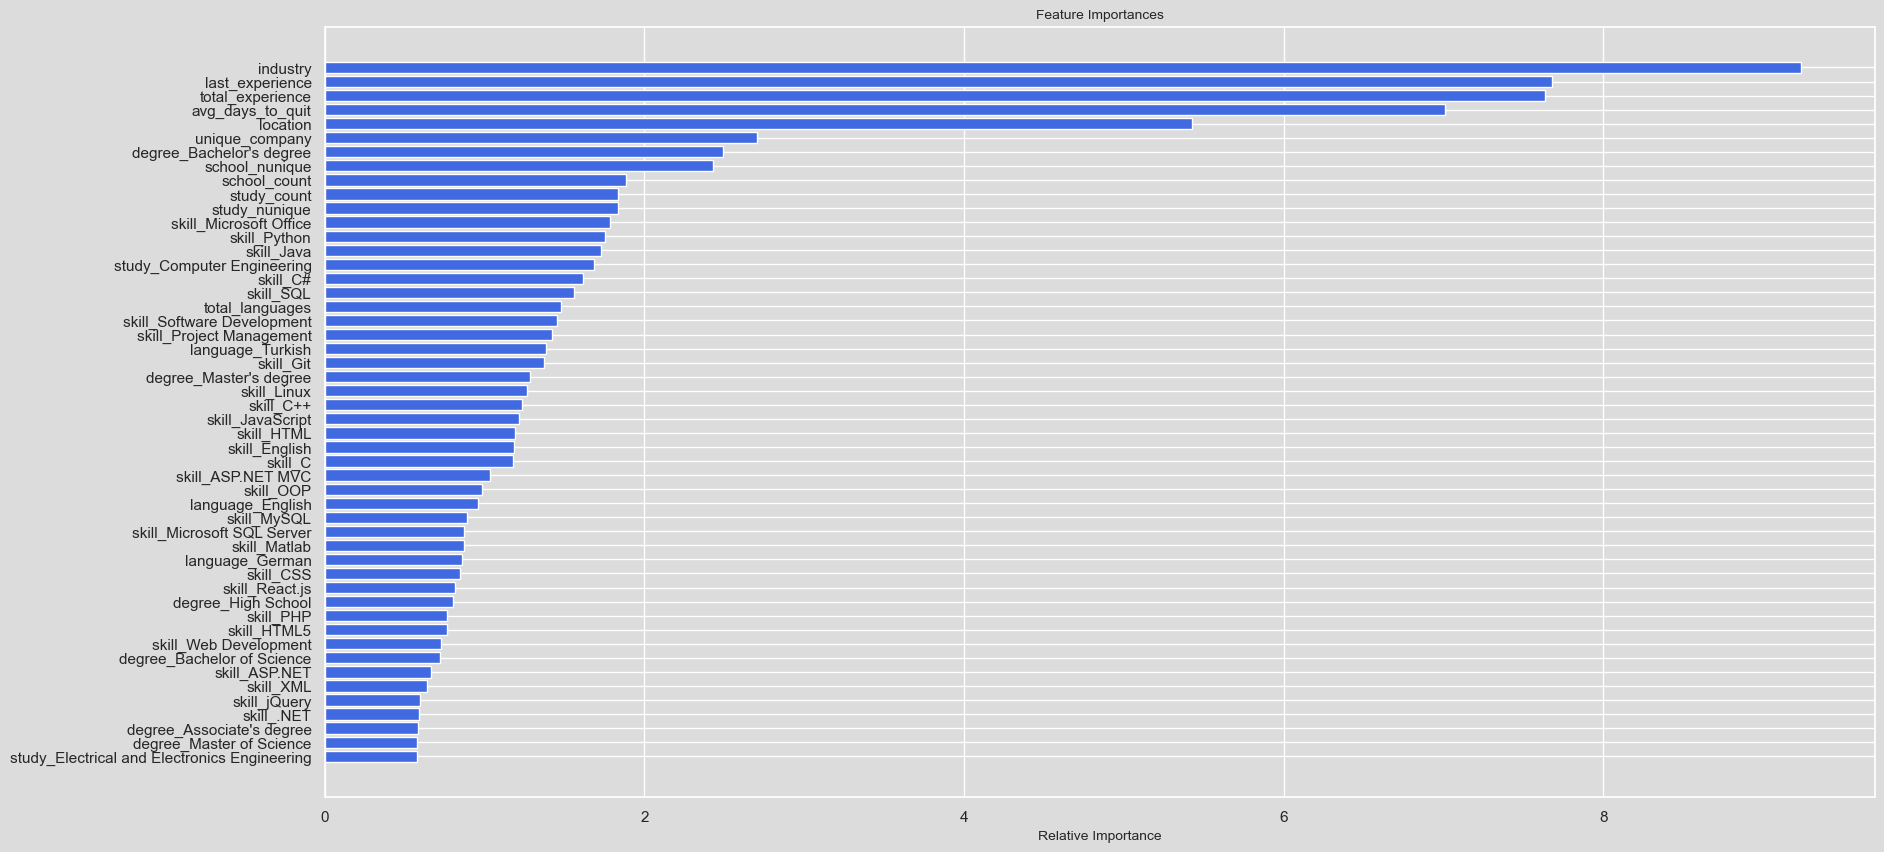

fold accuracy: 0.7499151295688582
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6277670	test: 0.6277017	best: 0.6277017 (0)	total: 18.6ms	remaining: 1m 32s
200:	learn: 0.7323797	test: 0.6943533	best: 0.6943533 (199)	total: 2.89s	remaining: 1m 9s
400:	learn: 0.7776923	test: 0.7123458	best: 0.7131379 (397)	total: 5.75s	remaining: 1m 5s
600:	learn: 0.8075913	test: 0.7211723	best: 0.7212855 (575)	total: 8.69s	remaining: 1m 3s
800:	learn: 0.8312888	test: 0.7301120	best: 0.7307910 (796)	total: 11.5s	remaining: 1m
1000:	learn: 0.8499615	test: 0.7354306	best: 0.7357701 (956)	total: 14.2s	remaining: 56.8s
1200:	learn: 0.8647639	test: 0.7408623	best: 0.7412018 (1186)	total: 17s	remaining: 53.7s
1400:	learn: 0.8800190	test: 0.7431255	best: 0.7439176 (1360)	total: 19.8s	remaining: 50.8s
1600:	learn: 0.8927844	test: 0.7461808	best: 0.7467466 (1597)	total: 22.6s	remaining: 47.9s
1800:	learn: 0.9032638	test: 0.7486704	best: 

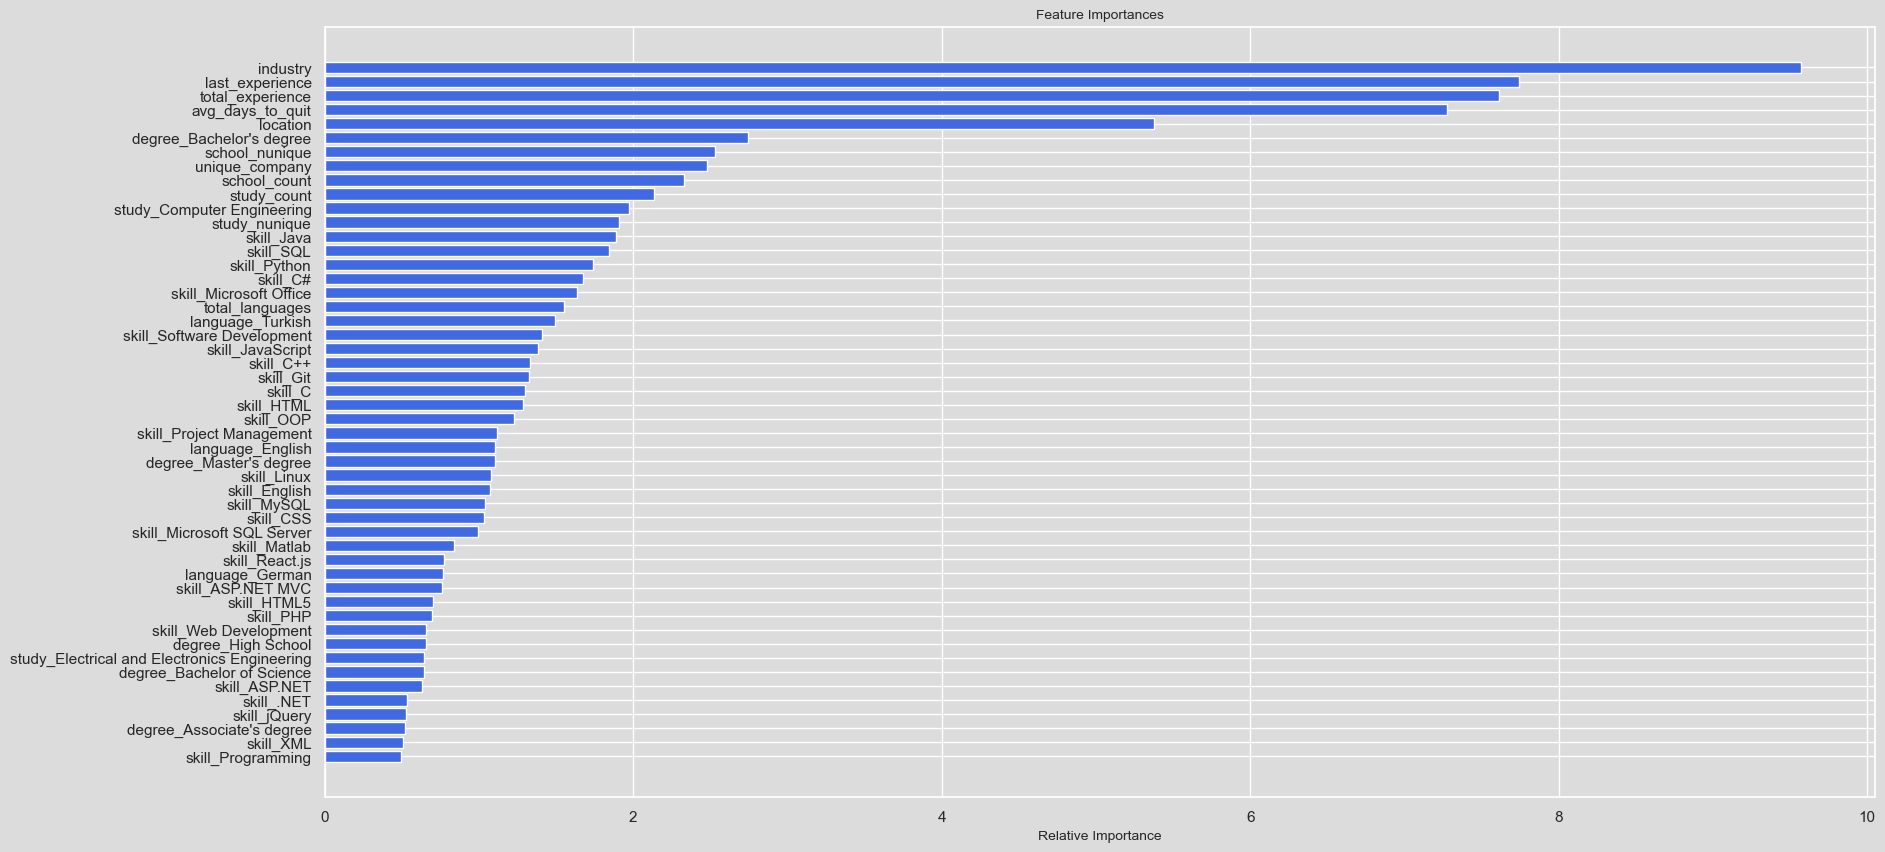

fold accuracy: 0.7701708724680322
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6286044	test: 0.6247595	best: 0.6247595 (0)	total: 15ms	remaining: 1m 15s
200:	learn: 0.7363180	test: 0.6924296	best: 0.6928822 (189)	total: 2.8s	remaining: 1m 6s
400:	learn: 0.7776470	test: 0.7111011	best: 0.7114405 (397)	total: 5.65s	remaining: 1m 4s
600:	learn: 0.8094699	test: 0.7201539	best: 0.7204934 (591)	total: 8.46s	remaining: 1m 1s
800:	learn: 0.8314019	test: 0.7256988	best: 0.7256988 (797)	total: 11.2s	remaining: 58.9s
1000:	learn: 0.8496220	test: 0.7309042	best: 0.7315831 (981)	total: 14s	remaining: 56s
1200:	learn: 0.8648997	test: 0.7353174	best: 0.7365622 (1183)	total: 16.9s	remaining: 53.5s
1400:	learn: 0.8789100	test: 0.7388254	best: 0.7389386 (1398)	total: 19.7s	remaining: 50.7s
1600:	learn: 0.8914490	test: 0.7443703	best: 0.7453887 (1584)	total: 22.6s	remaining: 47.9s
1800:	learn: 0.9031506	test: 0.7466335	best: 0.

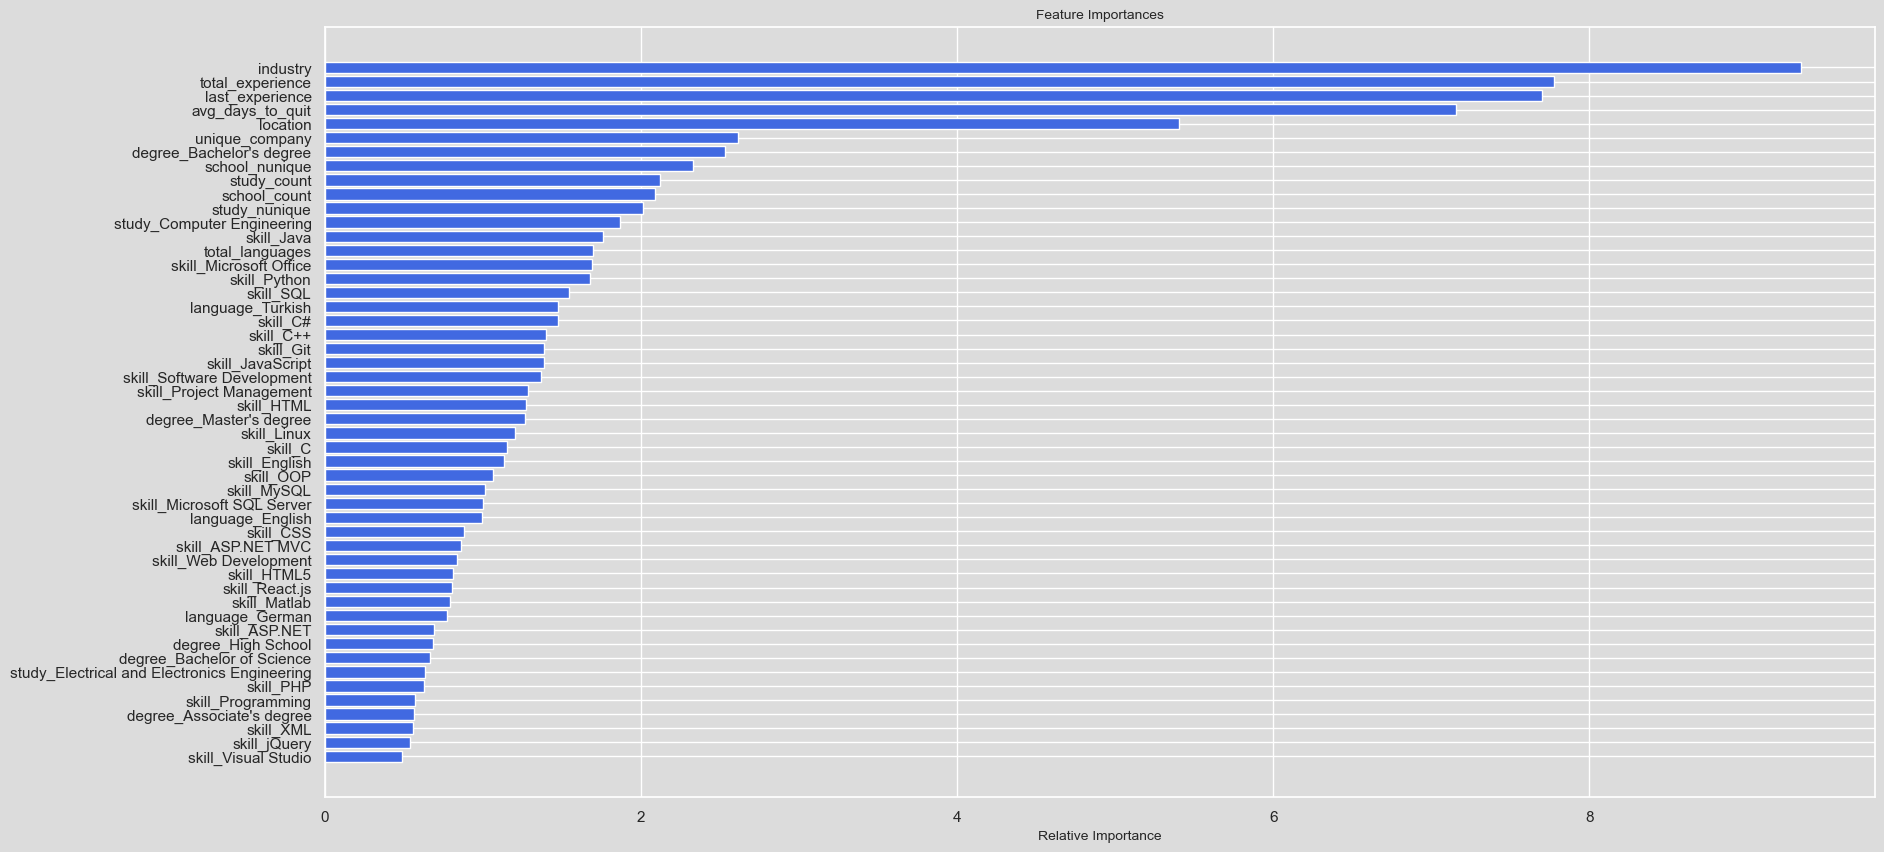

fold accuracy: 0.7602127418807287
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6248331	test: 0.6215482	best: 0.6215482 (0)	total: 13.2ms	remaining: 1m 5s
200:	learn: 0.7339927	test: 0.6867361	best: 0.6871888 (196)	total: 2.85s	remaining: 1m 8s
400:	learn: 0.7784668	test: 0.7076732	best: 0.7080127 (396)	total: 5.69s	remaining: 1m 5s
600:	learn: 0.8070751	test: 0.7176324	best: 0.7177456 (576)	total: 8.43s	remaining: 1m 1s
800:	learn: 0.8276486	test: 0.7248755	best: 0.7251019 (796)	total: 11.1s	remaining: 58.3s
1000:	learn: 0.8460268	test: 0.7329108	best: 0.7331372 (988)	total: 14.2s	remaining: 56.8s
1200:	learn: 0.8627526	test: 0.7361928	best: 0.7361928 (1194)	total: 17s	remaining: 53.9s
1400:	learn: 0.8778263	test: 0.7417383	best: 0.7420779 (1399)	total: 19.8s	remaining: 50.9s
1600:	learn: 0.8914967	test: 0.7452467	best: 0.7458126 (1597)	total: 22.6s	remaining: 48s
1800:	learn: 0.9035149	test: 0.7478497	best: 

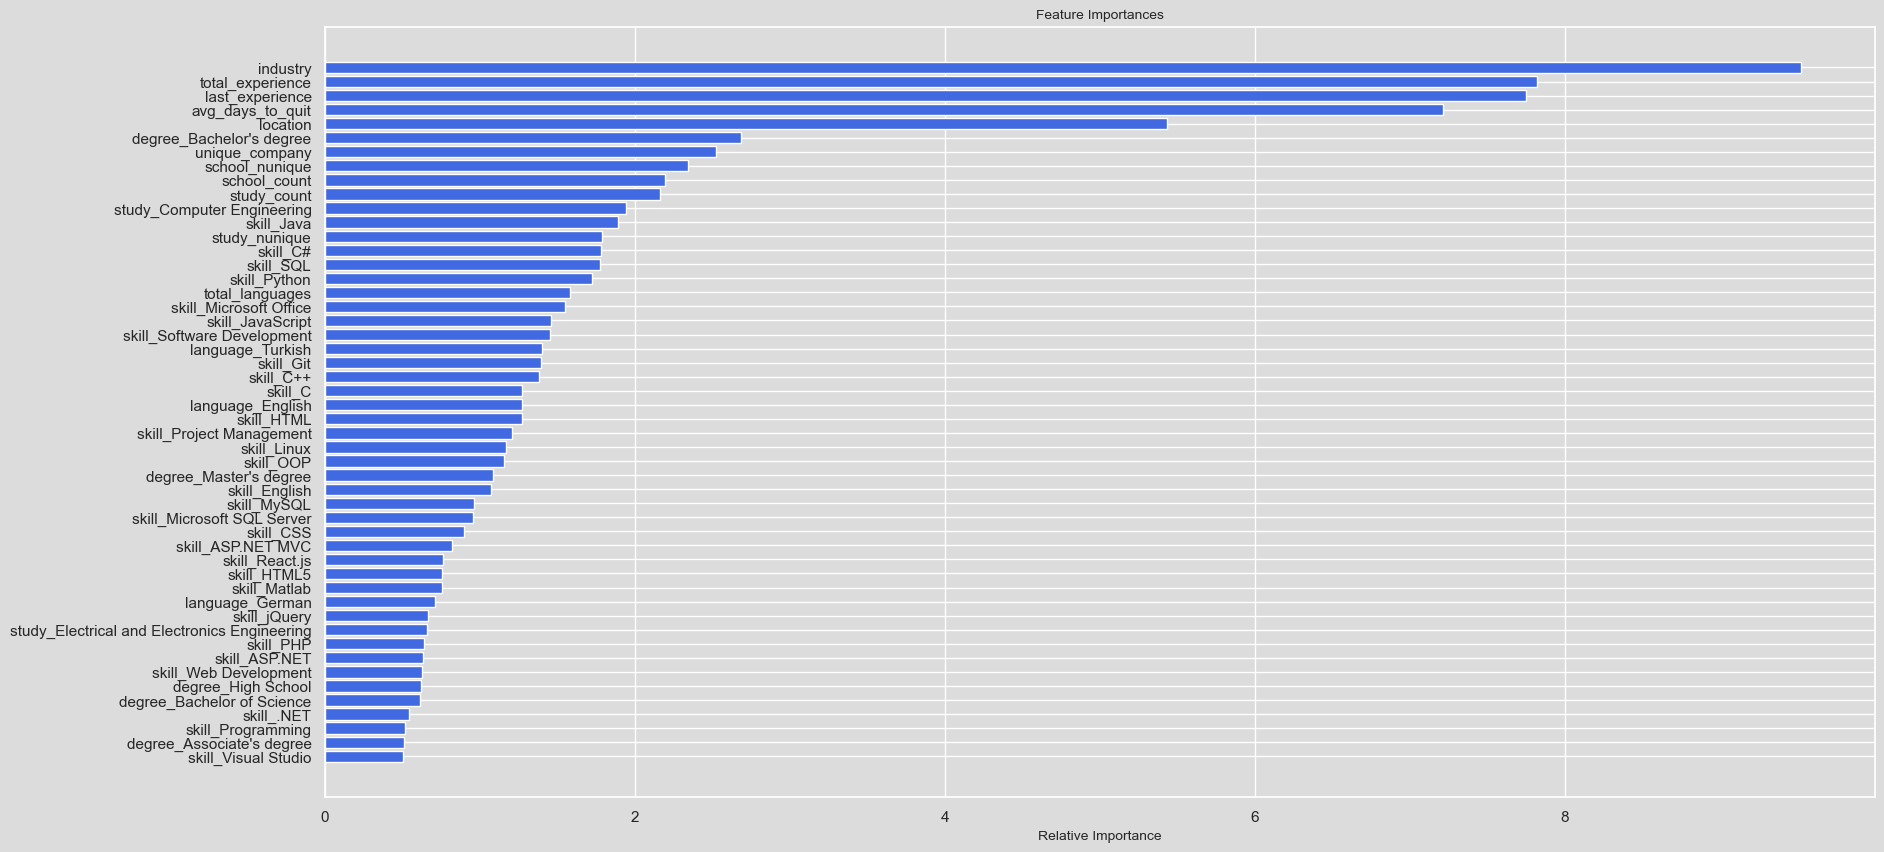

fold accuracy: 0.7657311000452693
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6266664	test: 0.6207560	best: 0.6207560 (0)	total: 17.7ms	remaining: 1m 28s
200:	learn: 0.7341738	test: 0.6849253	best: 0.6852648 (195)	total: 3.43s	remaining: 1m 21s
400:	learn: 0.7783084	test: 0.7095971	best: 0.7101630 (399)	total: 6.73s	remaining: 1m 17s
600:	learn: 0.8066904	test: 0.7198959	best: 0.7209144 (592)	total: 10.1s	remaining: 1m 13s
800:	learn: 0.8296856	test: 0.7273653	best: 0.7273653 (796)	total: 13.3s	remaining: 1m 9s
1000:	learn: 0.8497386	test: 0.7309869	best: 0.7318923 (964)	total: 16.7s	remaining: 1m 6s
1200:	learn: 0.8643370	test: 0.7355138	best: 0.7360797 (1197)	total: 20s	remaining: 1m 3s
1400:	learn: 0.8796370	test: 0.7400407	best: 0.7406066 (1395)	total: 23.3s	remaining: 59.8s
1600:	learn: 0.8929000	test: 0.7436623	best: 0.7446809 (1479)	total: 26.5s	remaining: 56.4s
1800:	learn: 0.9025643	test: 0.7438886	

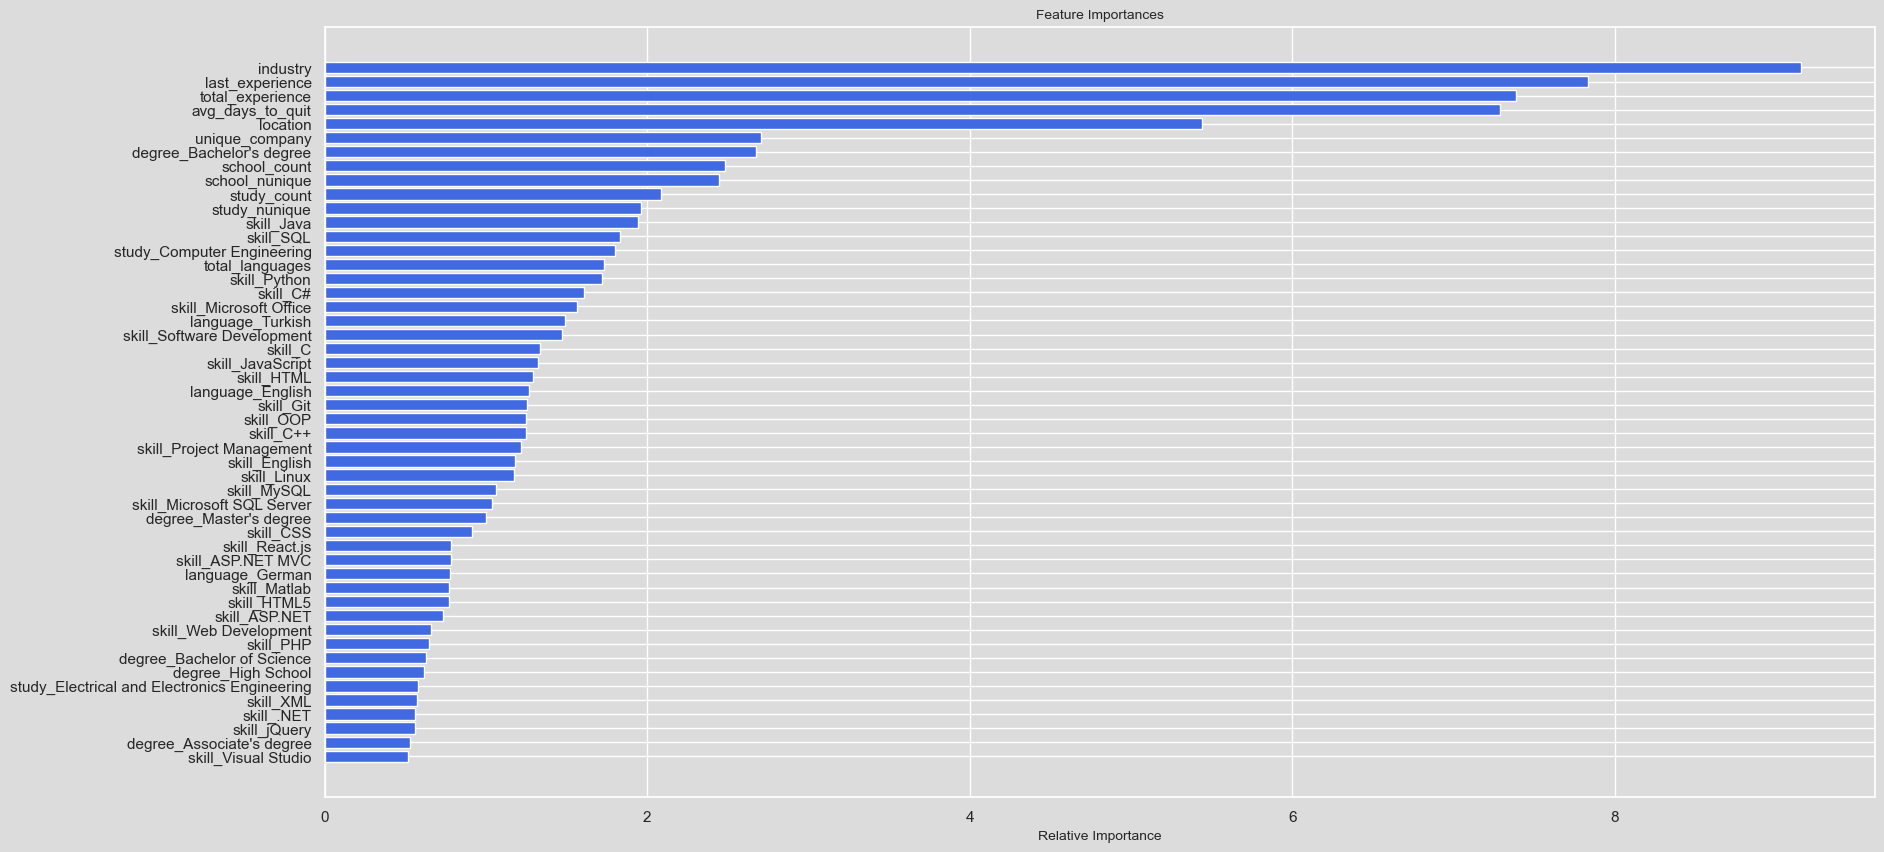

fold accuracy: 0.7667496604798552
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6326189	test: 0.6239249	best: 0.6239249 (0)	total: 15.9ms	remaining: 1m 19s
200:	learn: 0.7353281	test: 0.6825487	best: 0.6826618 (197)	total: 2.93s	remaining: 1m 10s
400:	learn: 0.7781500	test: 0.6974876	best: 0.6974876 (375)	total: 5.79s	remaining: 1m 6s
600:	learn: 0.8060793	test: 0.7134450	best: 0.7134450 (600)	total: 8.62s	remaining: 1m 3s
800:	learn: 0.8295046	test: 0.7237438	best: 0.7238569 (797)	total: 11.4s	remaining: 59.8s
1000:	learn: 0.8474300	test: 0.7298551	best: 0.7311000 (985)	total: 14.2s	remaining: 56.7s
1200:	learn: 0.8633411	test: 0.7358533	best: 0.7359665 (1198)	total: 17s	remaining: 53.9s
1400:	learn: 0.8789353	test: 0.7390222	best: 0.7390222 (1397)	total: 19.9s	remaining: 51.2s
1600:	learn: 0.8914741	test: 0.7416252	best: 0.7426437 (1555)	total: 22.8s	remaining: 48.3s
1800:	learn: 0.9041939	test: 0.7460389	be

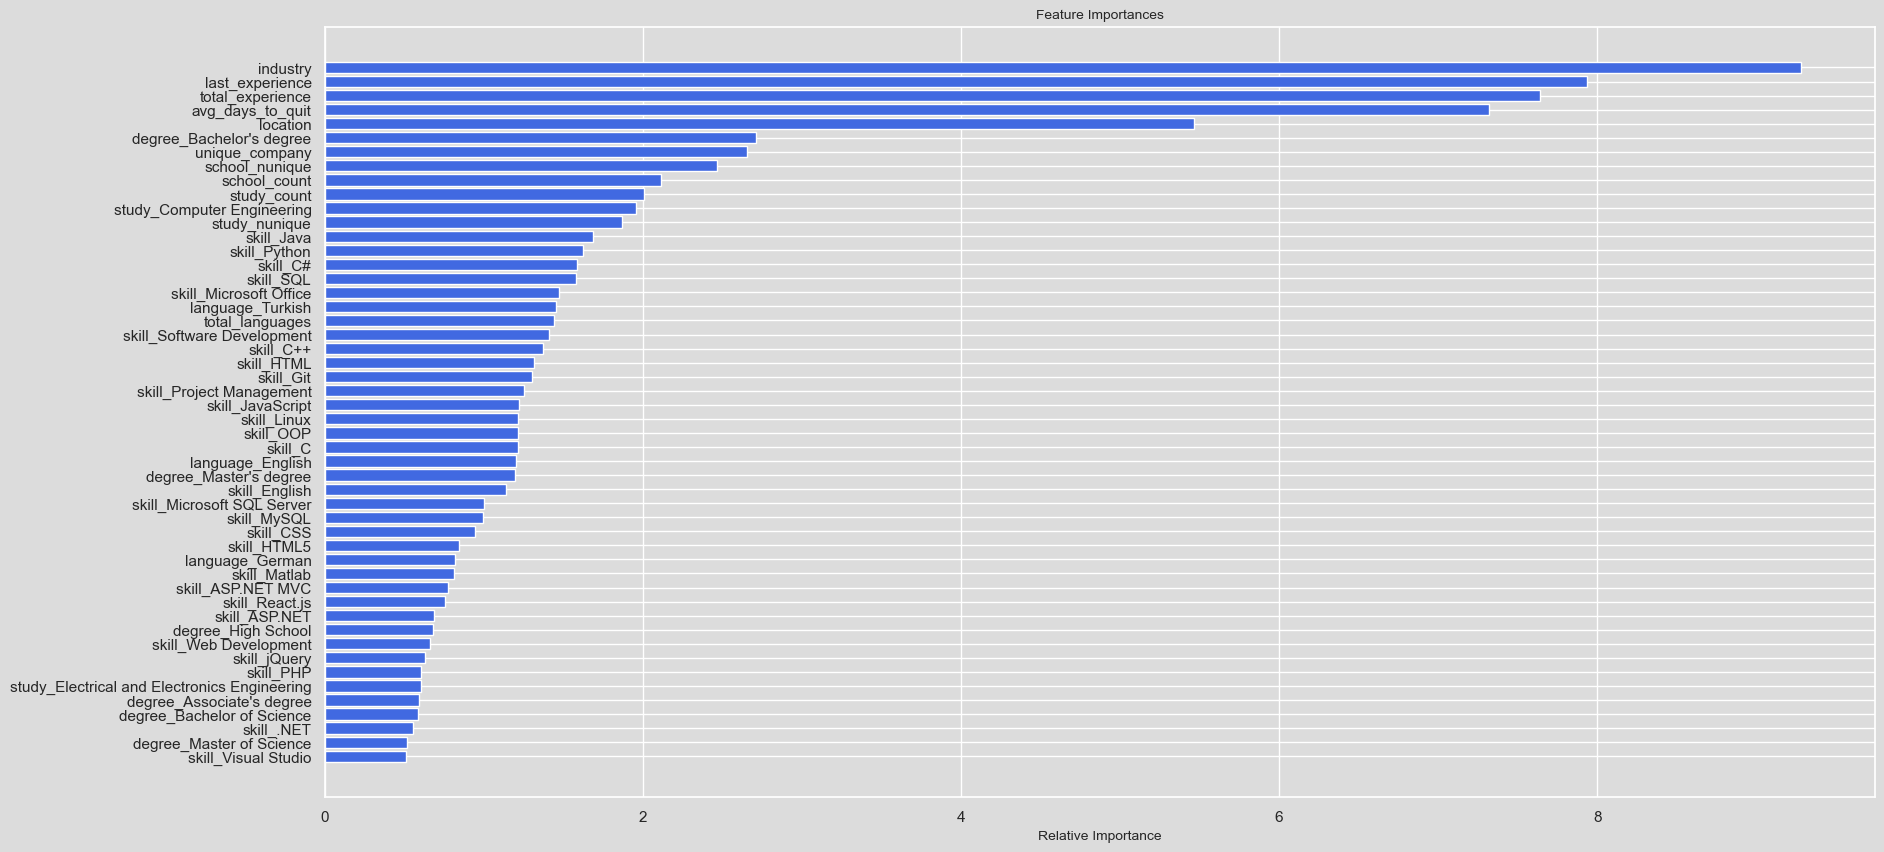

fold accuracy: 0.7606382978723404
accuracy: 0.762236179482827


In [77]:
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    #model = XGBClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')

In [78]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,0
2,2110,0
3,55082,0
4,37165,0


In [79]:
sub.to_csv(f'../submissions/submission_{round(val_score, 6)}.csv', index = False)